# imports

In [35]:
import pandas as pd
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt; plt.rcParams['font.family'] = 'Malgun Gothic'
# import seaborn as sns; sns.set_theme(font='Malgun Gothic')

# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


pd.set_option('display.max_rows', 100, 'display.max_columns', 100, 'max_colwidth', None)
import warnings; warnings.filterwarnings(action='ignore')

# 숫자 잘린거 다 보여주기
pd.options.display.float_format = '{:.5f}'.format

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300

In [36]:
import statsmodels
statsmodels.__version__ # 0.12.2

'0.12.2'

# read

In [37]:
df= pd.read_csv('./kospi.csv')
# df= pd.read_csv('./nasdaq.csv')
# df= pd.read_csv('./sp500.csv')

# ARIMA

In [38]:
df['Change']    = df['Close'].pct_change()
df['STDEV']     = df['Close'].rolling(window=20).std(ddof=0)
df['STDEV_log'] = np.log(df['Close'].rolling(window=20).std(ddof=0))
df['HV']        = df['Change'].rolling(window=20, center=False).std() * (252 ** 0.5)

In [39]:
df.tail()

,Date,Close,Open,High,Low,Volume,Change,STDEV,STDEV_log,HV
4517,2021-11-02,3013.49000,2995.58000,3034.30000,2995.58000,525850000.00000,0.01160,37.17328,3.61559,0.17002
4518,2021-11-03,2975.71000,3020.36000,3020.87000,2969.01000,658650000.00000,-0.01254,36.79914,3.60547,0.16199
4519,2021-11-04,2983.22000,3000.92000,3011.56000,2978.07000,772020000.00000,0.00252,31.79447,3.45929,0.14664
4520,2021-11-05,2969.27000,3003.53000,3003.53000,2953.96000,688030000.00000,-0.00468,31.33849,3.44485,0.13468
4521,2021-11-08,2960.20000,2965.36000,2968.18000,2930.90000,550610.00000,-0.00305,31.11492,3.43769,0.13511


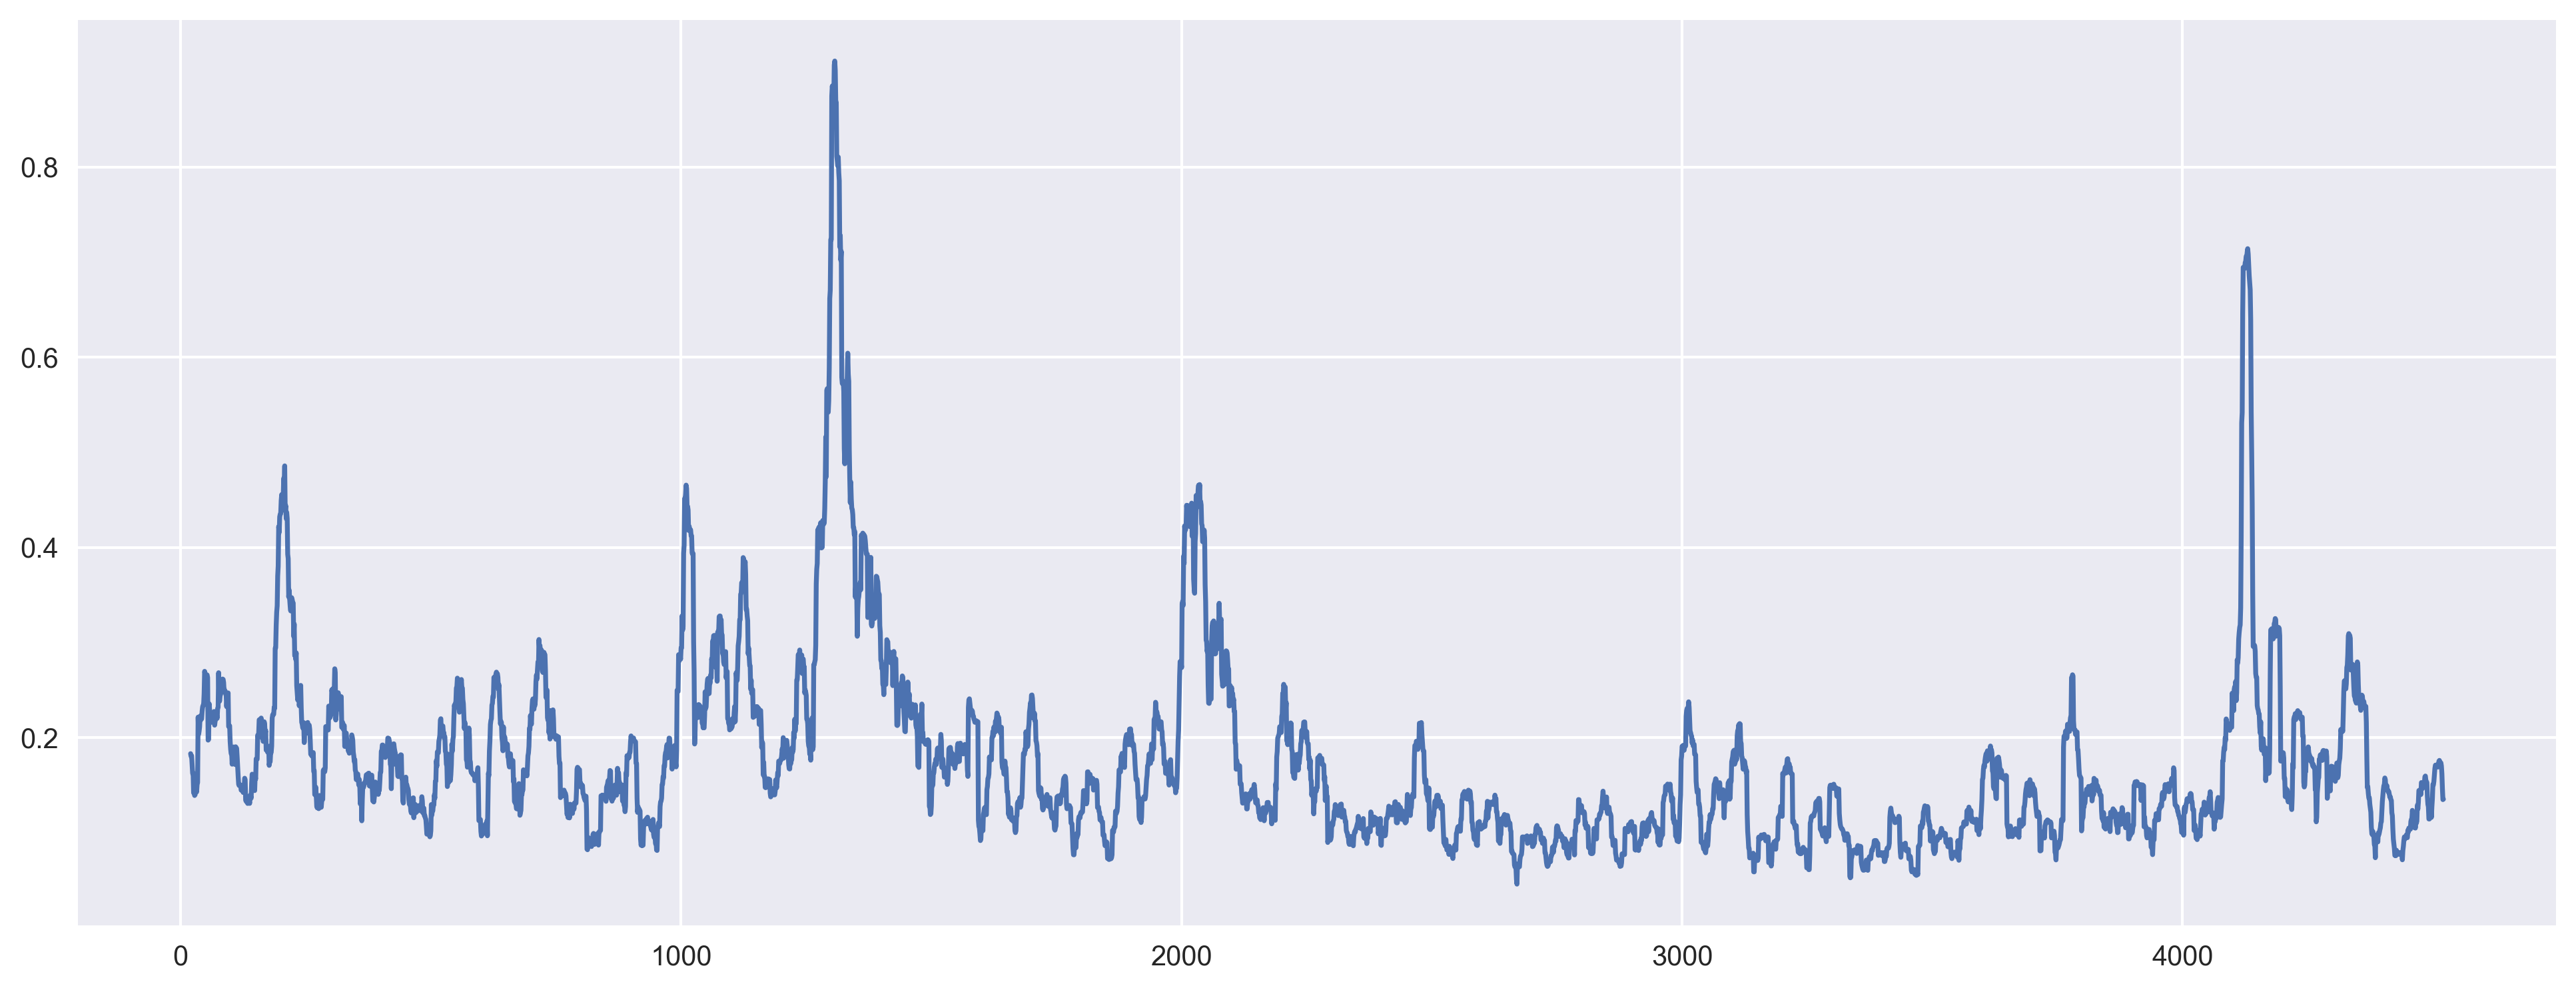

In [40]:
plt.figure(figsize=(16,6))
df['HV'].plot() # STDEV, STDEV_log, HV
plt.show()

In [41]:
# nan 값 삭제
df = df.dropna()

In [42]:
df.head()

,Date,Close,Open,High,Low,Volume,Change,STDEV,STDEV_log,HV
20,2003-08-27,758.98000,757.72000,763.99000,756.04000,497010000.00000,0.00794,19.19208,2.95450,0.18298
21,2003-08-28,752.81000,763.46000,765.27000,749.34000,461040000.00000,-0.00813,19.69886,2.98056,0.18010
22,2003-08-29,759.47000,756.76000,760.09000,746.92000,431260000.00000,0.00885,20.38638,3.01487,0.18084
23,2003-09-01,764.11000,763.22000,765.64000,759.36000,370540000.00000,0.00611,21.53935,3.06988,0.17111
24,2003-09-02,766.50000,768.43000,768.91000,763.34000,493040000.00000,0.00313,22.39438,3.10881,0.16228


In [43]:
# close_df = df[['Date','STDEV']]
# close_df = df[['Date','STDEV_log']]
close_df = df[['Date','HV']]

close_df = close_df.sort_values('Date')
close_df = close_df.set_index('Date')

In [44]:
train_df = close_df.loc['2003-09-29':'2020-09-28']    # 2003-9-29 ~ 2020-9-28
test_df = close_df.loc['2020-09-29':'2021-09-28']  # 2020-9-29 ~ 2021-9-28

In [45]:
train_df.tail()

,HV
Date,
2020-09-22,0.16430
2020-09-23,0.16420
2020-09-24,0.18433
2020-09-25,0.18388
2020-09-28,0.18651


In [46]:
test_df.tail()

,HV
Date,
2021-09-17,0.12975
2021-09-23,0.12715
2021-09-24,0.11428
2021-09-27,0.11427
2021-09-28,0.11953


# Auto Arima

In [47]:
model_arima= auto_arima(train_df, trace=True, error_action='ignore', start_p=1, start_q=1, max_p=4, max_q=4)
model_arima.fit(train_df)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-24990.637, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24882.865, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24905.759, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-24900.140, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24884.863, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-25023.524, Time=0.71 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-24993.976, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-25003.058, Time=1.33 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-25029.554, Time=0.87 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-25037.846, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-24974.403, Time=1.00 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-25031.338, Time=1.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-24979.589, Time=1.40 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-25036.153, Time=1.15 sec
 ARIM

ARIMA(order=(1, 1, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [48]:
tmp_dict = model_arima.to_dict()
tmp_dict['order']

(1, 1, 4)

In [49]:
@@@@@@확인
1. order
2. test_df 컬럼명

SyntaxError: invalid syntax (Temp/ipykernel_15780/21694073.py, line 1)

# ARIMA

In [50]:
model = ARIMA(train_df, order=(1,1,4))

arima_res = model.fit(trend='c', full_output=True, disp=1)
print(arima_res.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D.HV   No. Observations:                 4209
Model:                 ARIMA(1, 1, 4)   Log Likelihood               12529.954
Method:                       css-mle   S.D. of innovations              0.012
Date:                Mon, 15 Nov 2021   AIC                         -25045.908
Time:                        20:11:36   BIC                         -25001.493
Sample:                             1   HQIC                        -25030.205
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.872e-06      0.000     -0.013      0.990      -0.001       0.001
ar.L1.D.HV     0.7676      0.066     11.607      0.000       0.638       0.897
ma.L1.D.HV    -0.7211      0.067    -10.690      0.0

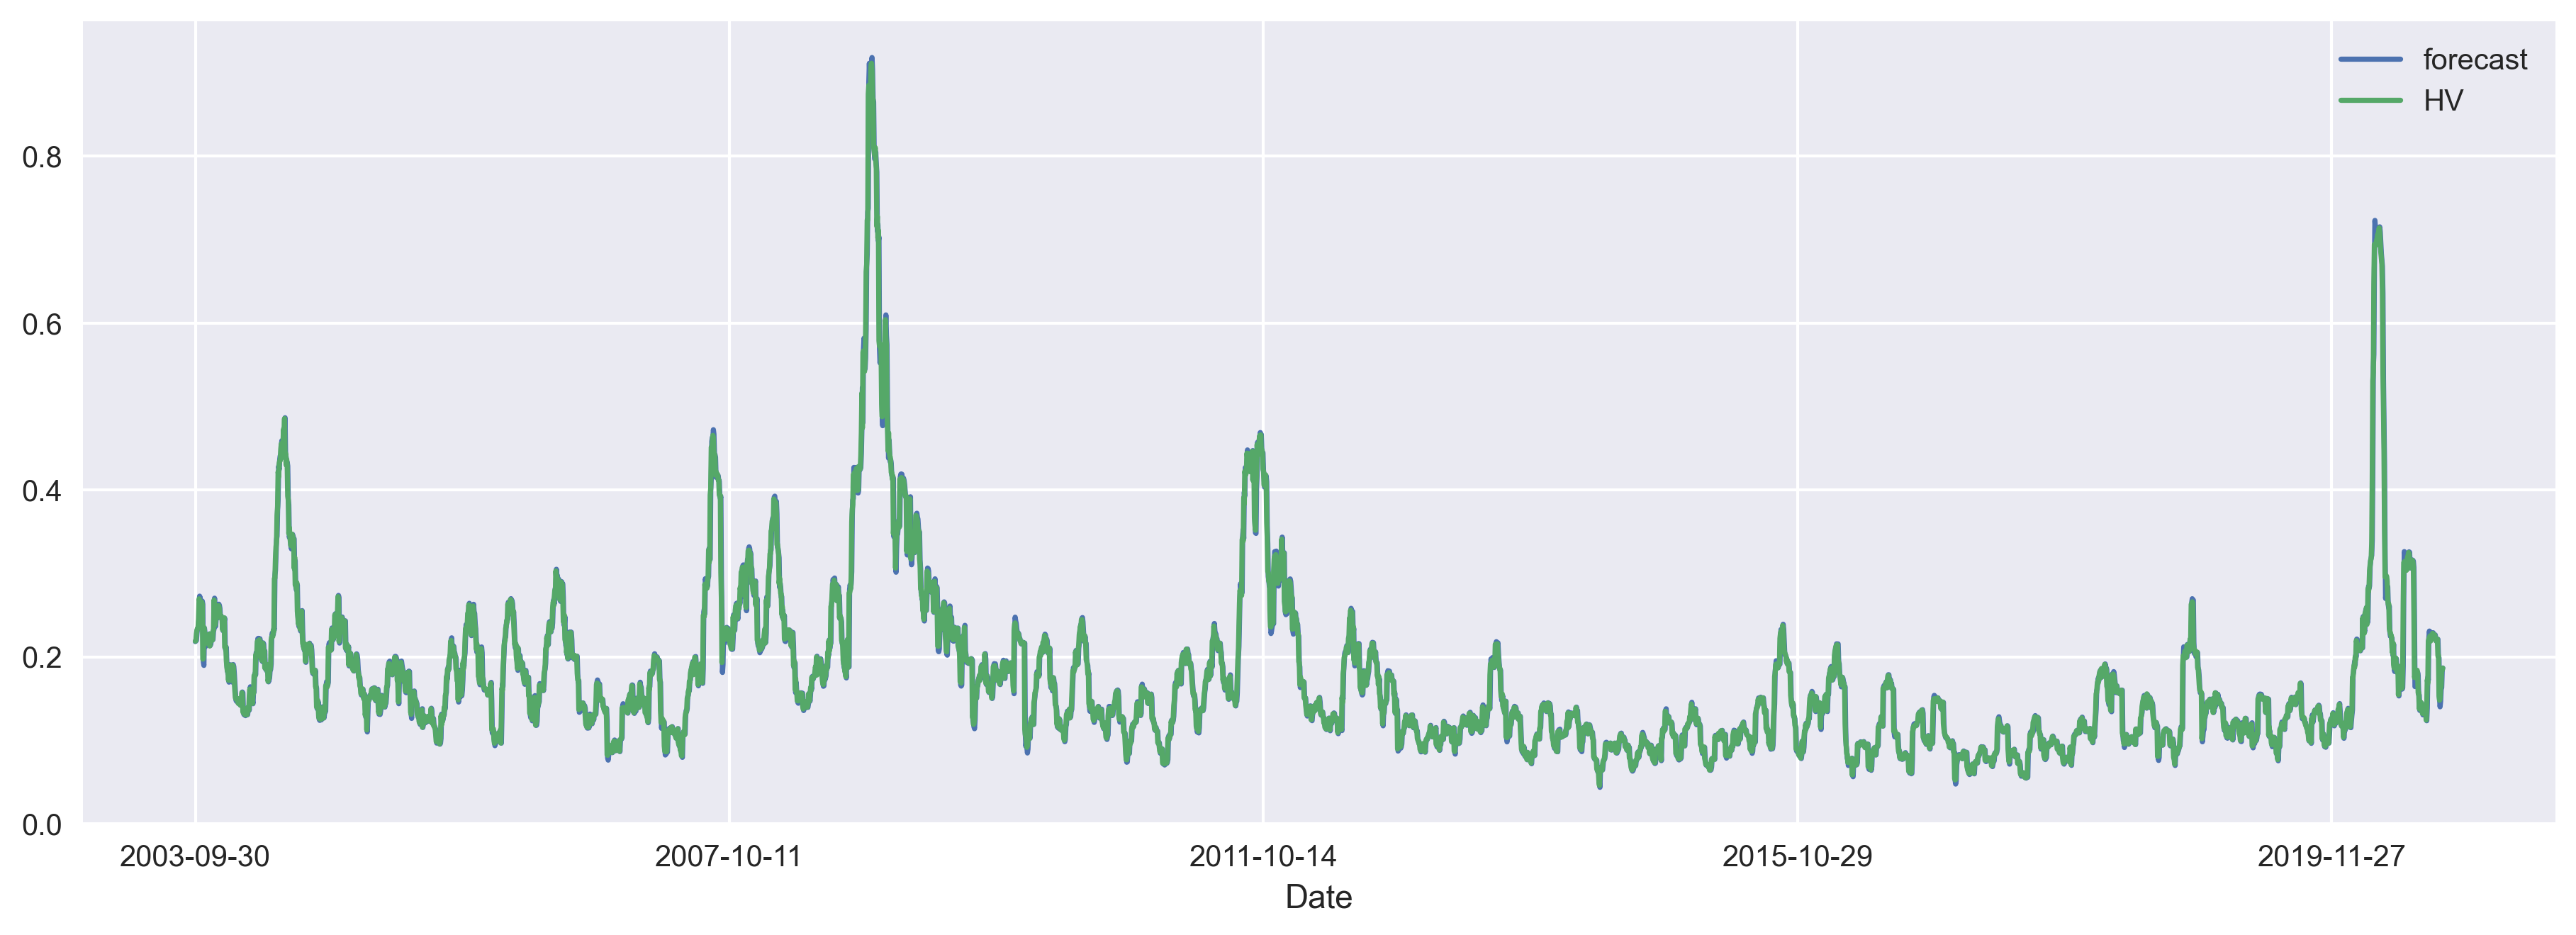

In [51]:
pig, ax = plt.subplots(figsize=(15,5))
arima_res.plot_predict(ax=ax)
plt.show()

# 1년치(2020-9-29 ~ 2021-9-28) 맞추기

In [52]:
forcast_245 = arima_res.forecast(steps=245) # 245: 245일 맞춰봐 
# 예측값, stderr,   upper bound~lower bound
forcast_245 = forcast_245[0]
print(forcast_245)

[0.18773167 0.18974157 0.19126492 0.19242617 0.19331663 0.19399923
 0.19452228 0.19492286 0.19522945 0.19546387 0.19564292 0.19577945
 0.19588335 0.1959622  0.19602182 0.19606669 0.19610023 0.19612507
 0.19614324 0.19615629 0.1961654  0.1961715  0.19617528 0.19617728
 0.19617792 0.1961775  0.19617629 0.19617446 0.19617215 0.19616948
 0.19616653 0.19616336 0.19616003 0.19615658 0.19615303 0.1961494
 0.19614572 0.19614199 0.19613823 0.19613444 0.19613064 0.19612681
 0.19612298 0.19611914 0.19611529 0.19611143 0.19610757 0.19610371
 0.19609985 0.19609598 0.19609211 0.19608825 0.19608438 0.19608051
 0.19607664 0.19607276 0.19606889 0.19606502 0.19606115 0.19605728
 0.19605341 0.19604954 0.19604566 0.19604179 0.19603792 0.19603405
 0.19603018 0.1960263  0.19602243 0.19601856 0.19601469 0.19601081
 0.19600694 0.19600307 0.1959992  0.19599533 0.19599145 0.19598758
 0.19598371 0.19597984 0.19597597 0.19597209 0.19596822 0.19596435
 0.19596048 0.1959566  0.19595273 0.19594886 0.19594499 0.19594

In [53]:
len(forcast_245)

245

In [54]:
real = np.array(test_df['HV'])
real

array([0.18549963, 0.19011086, 0.18398008, 0.18210116, 0.1807159 ,
       0.17961053, 0.1749052 , 0.1756512 , 0.17781449, 0.17204016,
       0.17000714, 0.17169473, 0.16849661, 0.16931315, 0.16676115,
       0.1450956 , 0.1465782 , 0.11130133, 0.11619168, 0.1417597 ,
       0.14846741, 0.15669981, 0.15777838, 0.17708605, 0.17701122,
       0.18164454, 0.18164591, 0.18224691, 0.179791  , 0.17592152,
       0.18531693, 0.18633885, 0.18629597, 0.18269592, 0.18270269,
       0.18532659, 0.18080549, 0.18580337, 0.17955571, 0.13604223,
       0.15680423, 0.15461291, 0.1585566 , 0.14455577, 0.14587438,
       0.14384844, 0.16349873, 0.1698037 , 0.16920712, 0.1694647 ,
       0.16283747, 0.16304075, 0.16298236, 0.16338667, 0.16377118,
       0.15384851, 0.16826063, 0.16709754, 0.17308625, 0.1733607 ,
       0.15769824, 0.16016336, 0.17128512, 0.17534754, 0.17834188,
       0.18847993, 0.20841626, 0.20539679, 0.20834889, 0.20822615,
       0.20656315, 0.2261099 , 0.24856749, 0.25945932, 0.25881

In [55]:
len(real)

245

# RMSE 확인

In [56]:
from sklearn.metrics import mean_squared_error

mean_squared_error(real, forcast_245, squared=False)

0.06910620712668585